In [1]:
import sys
sys.path.append('../')

# Diving into scans-preprocessing with RadIO

## Quick reminder

Hello again! This is the second tutorial in the series, dedicated to the lung cancer research with RadIO. In the [first notebook](link-on-first) we talked about using RadIO to create a `Dataset` of scans from [LUNA16 competition dataset](https://luna16.grand-challenge.org/). In short, `Dataset` simplifies operating with large datasets that cannot fit in memory (see more [here](link-on-dataset)). Setting up a `Dataset` takes only several lines of code:

In [6]:
from radio.dataset import FilesIndex, Dataset
from radio import CTImagesMaskedBatch

LUNA_MASK = '/data/MRT/luna/s*/*.mhd'                                      # set glob-mask for scans from Luna-dataset here
luna_index = FilesIndex(path=LUNA_MASK, no_ext=True)                       # preparing indexing structure
luna_dataset = Dataset(index=luna_index, batch_class=CTImagesMaskedBatch)

We've also seen how easy it is to build simple preprocessing pipelines, that include `load` of data from disk and `resize` of scans to differrent shape:

In [439]:
from radio.dataset import Pipeline
preprocessing = (Pipeline()                      # initialize empty workflow
                 .load(fmt='raw')                # add load of scans from MetaImage to the workflow
                 .resize(shape=(92, 256, 256)))  # add resize to a shape to the workflow. Nothing is computed here,
                                                 # the whole thing is lazy!

..and generate a batch with 3 loaded and resized scans: 

In [4]:
batch = (luna_dataset >> preprocessing).next_batch(3)  # pass a batch of luna-scans of size 3 through the workflow 

In this tutorial we are diving deeper into preprocessing with RadIO. We will cover actions that allow to considerably augment Luna-dataset. `sample_nodules` - action, that samples cancerous/non-cancerous scan-crops, `unify_spacing`, `rotate`, `central_crop` are among actions, that help to perform augmentation. What's more, we will cover actions `create_mask` and `fetch_nodules_info`, that will help you to transform with ease [Luna cancer annotations](link-on-annots) into *cancerous masks*, **target (Y)** for segmenting nets (think of [Vnet](Vnet-link)). In short, after reading this tutorial you will be able to prepare a large and augmented dataset of crops for training [Vnet](Vnet-link).

## Augmentation of Luna


###  `unify_spacing`: alternative to `resize`

Not infrequently, scans in the dataset have drastically different scales. Take a look at two slices from different scans below: 

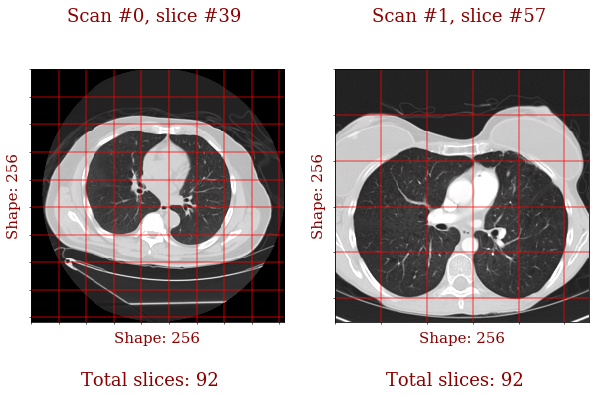

In [440]:
from utils import show_slices
import numpy as np
ixs = np.array(['1.3.6.1.4.1.14519.5.2.1.6279.6001.219618492426142913407827034169',
                '1.3.6.1.4.1.14519.5.2.1.6279.6001.185154482385982570363528682299'])
two_scans_dataset = Dataset(index=luna_index.create_subset(ixs), batch_class=CTImagesMaskedBatch)
batch = (two_scans_dataset >> preprocessing).next_batch(2, shuffle=False)   # pass a batch through the workflow
show_slices(batch, scan_indices=[0, 1], ns_slice=[39, 57], grid=True)

As you can see, lungs on the right scan are clearly bigger than on the left one. In this case you may say that left and right scans have different **spacings**: the distance between adjacent pixels on the left scan is larger than on the right one. This is demonstrated by grids on both plots: the number of pixels to define 5 cm of the *real-world distance* is lesser for the left scan. 

In all, **Luna-dataset** incorporates variability, that is related to *peculiarities of data representation*, rather than *structural differences.* Gladly, with action `unify_spacing` from RadIO you can easily make the scans more isotropic, thus eliminating needless variability from the dataset. 

Let us prepare preprocessing pipeline containing `load` of data from disk and action `unify_spacing`:

In [442]:
preprocessing = (Pipeline()
                 .load(fmt='raw')
                 .unify_spacing(spacing=(3.5, 1.0, 1.0), shape=(92, 256, 256)))

Pass a batch through the preprocessing pipeline and check out the result:

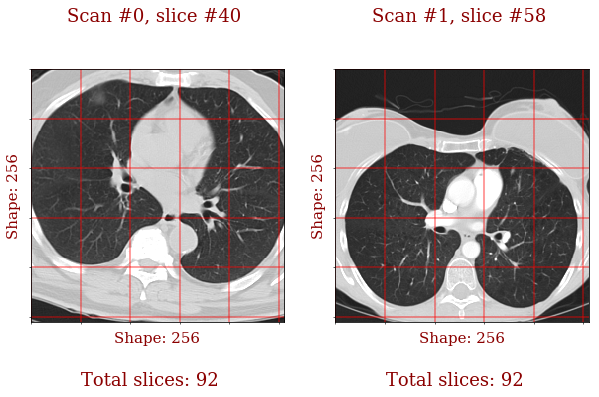

In [443]:
batch_unified = (two_scans_dataset >> preprocessing).next_batch(2, shuffle=False)
show_slices(batch_unified, scan_indices=[0, 1], ns_slice=[40, 58], grid=True)

You can see that lungs are much more similar in size, as they have the same scales. The remaining difference in sizes of lungs is expalined fully by difference in dimensions of patients, participated in studies.

To get an understanding of `unify_spacing`, compare the same scan *before and after* the action:

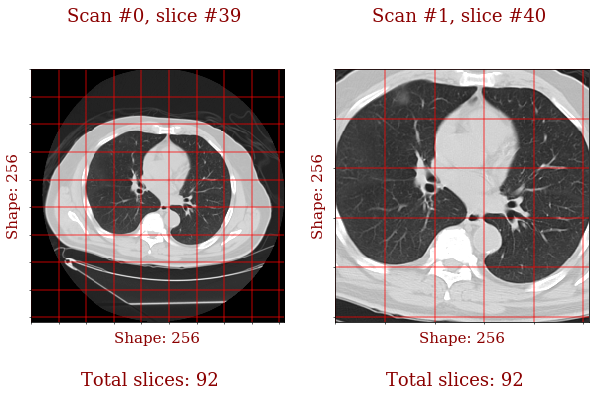

In [445]:
show_slices([batch, batch_unified], scan_indices=[0, 0], ns_slice=[39, 40], grid=True)

`unify_spacing` cropped the central part of the scan and zoomed it in, so that the new scans' spacing be equal to the supplied one (`[3.5, 1.0, 1.0]` in our case).

Essentially, `unify_spacing` is always a combination of *resize* (for manipulation with spacing) and *croping/padding* (for adjustment of shapes). The most important parameters of the action are

#### always supply these:
* `shape` - resulting shape of scans, sequence of three elements
* `spacing` - resulting spacing of scans, sequence of three elements

#### tweak these for better performance:
* `padding` - mode of padding. We recommend to use "`reflect`" (default), as it adds the least amount of artefacts. See [doc](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.pad.html) of `numpy.pad`
* `method` - choose between "`scipy`" and "`pil-simd` (default)". The first one parallelizes better on systems with large number of cores, but yields more artefacts.  

### `unify_spacing` as an agumenting action

So, how `unify_spacing` is an augmenting action? The idea is to slightly modify spacings of scans between different runs of `next_batch`. This allows to *controllably* introduce variability in the dataset. Say, you want the spacing to be randomly chosen from small set of predefined options. Assume, these options are

In [429]:
spacing_options = [(3.5, 0.5, 0.5), (3.5, 1.0, 1.0), (3.5, 1.5, 1.5), (3.5, 2.0, 2.0)]

The first step is to define *spacing randomizer*, a function that randomly fetches spacing:

In [430]:
spacing_randomizer = lambda *args: spacing_options[np.random.choice(range(len(spacing_options)))]

In [431]:
spacing_randomizer()

(3.5, 0.5, 0.5)

You can now set up the pipeline that generates random spacing for each run of `next_batch`.

In [432]:
from radio.dataset import F                                                 # see below the explanation
augmenting_pipeline = (Pipeline()                                           # empty workflow
                       .load(fmt='raw')                                     # load scans
                       .unify_spacing(spacing=F(spacing_randomizer), shape=(92, 256, 256)))

Note that spacing-parameter is set to `F(spacing_randomizer)`. Literally, this means the following: for each batch, passing through `augmenting_pipeline`, the spacing-argument is to be computed by the function `spacing_randomizer`(`F` stands for `F`unction). Pass the same batch through the workflow twice

In [433]:
np.random.seed(42)

In [434]:
batch_1 = (two_scans_dataset >> augmenting_pipeline).next_batch(2, shuffle=False)
batch_2 = (two_scans_dataset >> augmenting_pipeline).next_batch(2, shuffle=False)

...and see the result by yourself:

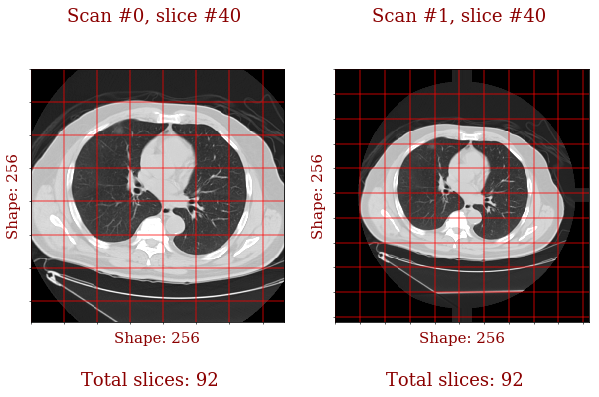

In [435]:
show_slices([batch_1, batch_2], scan_indices=[0, 0], ns_slice=[40, 40], grid=True)

### More augmenting actions: `rotate`, `central_crop`

For more augmentation you can `rotate` scans on random/specified angle, or crop out central part of scans using `central_crop`. You can of course combine these actions with others from RadIO in a single workflow:

In [460]:
augmenting_pipeline = (Pipeline()                                    # init empty workflow
                       .load(fmt='raw')                              # load data from disk
                       .resize(shape=(92, 256, 256), method='scipy') # resize with scipy
                       .rotate(angle=30, random=False)               # rotate with on 30 degrees
                       .central_crop(crop_size=(92, 168, 168)))      # perform central_crop

Pass a batch through the pipeline:

In [461]:
batch_augmented = (two_scans_dataset >> augmenting_pipeline).next_batch(2, shuffle=False)

the effect of augmenting actions is evident, if you put the same batch through the simple preprocessing workflow and compare the results:

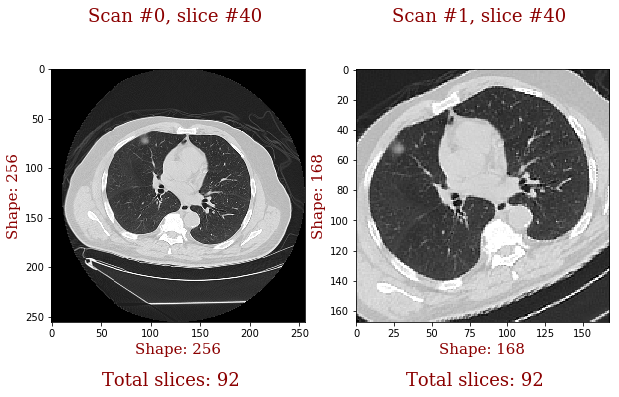

In [463]:
preprocessing_simple = (Pipeline()
                        .load(fmt='raw')
                        .resize(shape=(92, 256, 256), method='scipy'))
batch = (two_scans_dataset >> preprocessing_simple).next_batch(2, shuffle=False)
show_slices([batch, batch_augmented], [0, 0], 40, grid=False)

## Working with target-output of a net